# Companies Bankruptcy Forecast

A classifier for bankruptcy status prediction based on bankruptcy dataset provided by GA

For the Commuting hackathon

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 100

# plt.style.use("seaborn")

import warnings

warnings.filterwarnings("once")

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, auc

from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, scale
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV


In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

## Data

### Data description and dictionary

The dataset is about bankruptcy prediction of companies. 

* *Train Dataset.csv* - training set with both predictors and response variable
* *Test Dataset.csv.* - test set with ID and predictors


In [4]:
train_raw = pd.read_csv("data/Train Dataset.csv")
test_raw = pd.read_csv("data/Test Dataset.csv")

display(train_raw.head(5))

,company_id,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,...,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs /total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities *365) / sales,sales / short-term liabilities,sales / fixed assets,bankruptcy_label
0,0,0.159290,0.46240,0.07773,1.1683,-44.853,0.467020,0.189480,0.82895,1.1223,...,0.108990,0.41557,0.89101,0.001422,7.7928,4.9914,119.810,3.0465,3.0560,0
1,1,-0.127430,0.46243,0.26917,1.7517,7.597,0.000925,-0.127430,1.16250,1.2944,...,-0.089372,-0.23704,1.06250,0.150410,5.4327,3.4629,100.970,3.6150,3.4725,0
2,2,0.070488,0.23570,0.52781,3.2393,125.680,0.163670,0.086895,2.87180,1.0574,...,0.054286,0.10413,0.94571,0.000000,7.1070,3.3808,76.076,4.7978,4.7818,0
3,3,0.136760,0.40538,0.31543,1.8705,19.115,0.504970,0.136760,1.45390,1.1144,...,0.102630,0.23203,0.89737,0.073024,6.1384,4.2241,88.299,4.1337,4.6484,0
4,4,-0.110080,0.69793,0.18878,1.2713,-15.344,0.000000,-0.110080,0.43282,1.7350,...,0.439880,-0.36440,0.57153,0.000000,18.8010,2.7925,146.390,2.4934,15.0360,0


<IPython.core.display.Javascript object>

In [5]:
data_dictionary = {f"attr{i}": c for i, c in enumerate(train_raw.columns) if c not in["bankruptcy_label", "company_id"]}

company_raw = train_raw.rename(columns={v: k for k, v in data_dictionary.items()}).set_index("company_id")
test_company_raw = test_raw.rename(columns={v: k for k, v in data_dictionary.items()}).set_index("company_id").drop("bankruptcy_label", axis=1)

display( company_raw.head() )

,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,...,attr56,attr57,attr58,attr59,attr60,attr61,attr62,attr63,attr64,bankruptcy_label
company_id,,,,,,,,,,,,,,,,,,,,,
0,0.159290,0.46240,0.07773,1.1683,-44.853,0.467020,0.189480,0.82895,1.1223,0.38330,...,0.108990,0.41557,0.89101,0.001422,7.7928,4.9914,119.810,3.0465,3.0560,0
1,-0.127430,0.46243,0.26917,1.7517,7.597,0.000925,-0.127430,1.16250,1.2944,0.53757,...,-0.089372,-0.23704,1.06250,0.150410,5.4327,3.4629,100.970,3.6150,3.4725,0
2,0.070488,0.23570,0.52781,3.2393,125.680,0.163670,0.086895,2.87180,1.0574,0.67689,...,0.054286,0.10413,0.94571,0.000000,7.1070,3.3808,76.076,4.7978,4.7818,0
3,0.136760,0.40538,0.31543,1.8705,19.115,0.504970,0.136760,1.45390,1.1144,0.58938,...,0.102630,0.23203,0.89737,0.073024,6.1384,4.2241,88.299,4.1337,4.6484,0
4,-0.110080,0.69793,0.18878,1.2713,-15.344,0.000000,-0.110080,0.43282,1.7350,0.30207,...,0.439880,-0.36440,0.57153,0.000000,18.8010,2.7925,146.390,2.4934,15.0360,0


In [6]:
print("Data Dictionary:\n")
print("bankruptcy_label: 0 = did not bankrupt; 1 = bankrupt\n")
_ = [print(f"{k}: {v}") for k, v in data_dictionary.items()]


Data Dictionary:

bankruptcy_label: 0 = did not bankrupt; 1 = bankrupt

attr1: net profit / total assets
attr2: total liabilities / total assets
attr3: working capital / total assets
attr4: current assets / short-term liabilities
attr5: [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365
attr6: retained earnings / total assets
attr7: EBIT / total assets
attr8: book value of equity / total liabilities
attr9: sales / total assets
attr10: equity / total assets
attr11: (gross profit + extraordinary items + financial expenses) / total assets
attr12: gross profit / short-term liabilities
attr13: (gross profit + depreciation) / sales
attr14: (gross profit + interest) / total assets
attr15: (total liabilities * 365) / (gross profit + depreciation)
attr16: (gross profit + depreciation) / total liabilities
attr17: total assets / total liabilities
attr18: gross profit / total assets
attr19: gross profit / sales
attr20: (inventory * 3

### Label balance check

In [7]:
# how many positive cases
print("Total positive cases:", company_raw["bankruptcy_label"].sum())

print(
    "Proportion of positive cases:",
    company_raw["bankruptcy_label"].sum() / len(company_raw),
)

Total positive cases: 515
Proportion of positive cases: 0.052593954248366014


<IPython.core.display.Javascript object>

### Entirety check

Remove feature columns that have more than 10% missing

In [8]:
def summary(df):
    missing = df.apply(
        [lambda c: c.isnull().sum(), lambda c: c.isnull().sum() / len(c) * 100]
    )
    missing.index = pd.Index(data=["missing", "missing%"], name="missing")
    return pd.concat([df.describe(), missing])


cr_summary = summary(company_raw)
tcr_summary = summary(test_company_raw)
display(cr_summary)

print("Columns with most missing values in the two datasets provided:")
display( cr_summary.loc["missing%"].sort_values(ascending=False).head(5) )
display( tcr_summary.loc["missing%"].sort_values(ascending=False).head(5) )


,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,...,attr56,attr57,attr58,attr59,attr60,attr61,attr62,attr63,attr64,bankruptcy_label
count,9791.000000,9791.000000,9791.000000,9749.000000,9.771000e+03,9791.000000,9791.000000,9773.000000,9792.000000,9791.000000,...,9771.000000,9791.000000,9776.000000,9791.000000,9178.000000,9760.000000,9.771000e+03,9749.000000,9561.000000,9792.000000
mean,0.043019,0.596404,0.130959,8.136600,6.465164e+01,-0.059273,0.059446,19.884016,1.882296,0.389040,...,-0.992263,0.035022,1.133287,0.856053,118.156064,25.194430,2.015157e+03,8.660813,35.949619,0.052594
std,0.359321,4.587122,4.559074,290.647281,1.475939e+04,6.812754,0.533344,698.697015,17.674650,4.590299,...,77.007971,8.945365,8.038201,26.393305,3230.316692,1099.260821,1.171461e+05,60.838202,483.318623,0.223233
min,-12.458000,0.000000,-445.910000,-0.045319,-3.794600e+05,-486.820000,-12.458000,-1.848200,-0.032371,-445.910000,...,-7522.100000,-597.420000,-30.892000,-284.380000,0.000000,-12.656000,-1.496500e+04,-0.024390,-0.000015,0.000000
25%,0.001321,0.263145,0.020377,1.047000,-5.121700e+01,-0.000578,0.003004,0.428300,1.006675,0.294440,...,0.003121,0.008768,0.885722,0.000000,5.356325,4.267700,4.323400e+01,2.938800,2.012900,0.000000
50%,0.041364,0.467740,0.199290,1.591800,-5.557600e-02,0.000000,0.048820,1.088700,1.161300,0.510450,...,0.043679,0.098026,0.958305,0.002129,9.482000,6.283550,7.472900e+01,4.848900,4.041600,0.000000
75%,0.111130,0.689255,0.410670,2.880400,5.573200e+01,0.065322,0.126940,2.691000,1.970225,0.714290,...,0.117170,0.242680,0.996163,0.211790,19.506000,9.938200,1.233450e+02,8.363800,9.413500,0.000000
max,20.482000,446.910000,22.769000,27146.000000,1.034100e+06,322.200000,38.618000,53209.000000,1704.800000,12.602000,...,112.020000,226.760000,668.750000,1661.000000,251570.000000,108000.000000,1.077900e+07,5662.400000,21153.000000,1.000000
missing,1.000000,1.000000,1.000000,43.000000,2.100000e+01,1.000000,1.000000,19.000000,0.000000,1.000000,...,21.000000,1.000000,16.000000,1.000000,614.000000,32.000000,2.100000e+01,43.000000,231.000000,0.000000
missing%,0.010212,0.010212,0.010212,0.439134,2.144608e-01,0.010212,0.010212,0.194036,0.000000,0.010212,...,0.214461,0.010212,0.163399,0.010212,6.270425,0.326797,2.144608e-01,0.439134,2.359069,0.000000


Columns with most missing values in the two datasets provided:


attr37    45.363562
attr27     6.546160
attr60     6.270425
attr45     6.260212
attr28     2.359069
Name: missing%, dtype: float64

attr37    43.113367
attr27     6.615905
attr60     4.534687
attr45     4.534687
attr24     2.284264
Name: missing%, dtype: float64

<IPython.core.display.Javascript object>

In [9]:
company_raw.drop("attr37", axis=1, inplace=True)
test_company_raw.drop("attr37", axis=1, inplace=True)

<IPython.core.display.Javascript object>

### Collinearity check

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif_(X, threshold=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [
            variance_inflation_factor(X.iloc[:, variables].values, ix)
            for ix in range(X.iloc[:, variables].shape[1])
        ]

        maxloc = vif.index(max(vif))
        if max(vif) > threshold:
            print(
                "dropping '"
                + X.iloc[:, variables].columns[maxloc]
                + "' at index: "
                + str(maxloc)
            )
            del variables[maxloc]
            dropped = True

    return list(X.columns[variables])


#non_collinear_features = calculate_vif_(company_raw.iloc[:, :-1].dropna(), threshold=10)
#print(non_collinear_features)

non_collinear_features = [
    'attr1',  'attr2',  'attr3',  'attr5', 
    'attr6', 'attr8', 'attr10', 'attr12',
    'attr13', 'attr15', 'attr20', 'attr21',
    'attr24', 'attr25', 'attr26', 'attr27',
    'attr32', 'attr33', 'attr34', 'attr35',
    'attr36', 'attr40', 'attr41', 'attr44',
    'attr45', 'attr47', 'attr48', 'attr49',
    'attr53', 'attr54', 'attr55', 'attr57',
    'attr59', 'attr60', 'attr61', 'attr64'
]


/usr/local/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


<IPython.core.display.Javascript object>

In [11]:
print(
    f"Maybe only {len(non_collinear_features)/(len(company_raw.columns)-1)*100:2.0f}% features are useful!"
)

Maybe only 57% features are useful!


<IPython.core.display.Javascript object>

### Distribution of the features

tl;dr :-)

### Prepare training data set

In [12]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight

X = company_raw.iloc[:, 0:-1].copy()
y = company_raw["bankruptcy_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=38, stratify=y
)

X_train_nocol = X_train[non_collinear_features]
X_test_nocol = X_test[non_collinear_features]

sample_weight = compute_sample_weight("balanced", y=y_train)
class_weight = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
print("Class weight: ", class_weight)

Class weight:  [0.52775543 9.50724638]


<IPython.core.display.Javascript object>

## Baseline Model based on PCA

              precision    recall  f1-score   support

           0       0.98      0.24      0.39      3062
           1       0.06      0.91      0.12       170

    accuracy                           0.28      3232
   macro avg       0.52      0.57      0.25      3232
weighted avg       0.93      0.28      0.37      3232

Precision:  0.06224737267582862
Recall:  0.9058823529411765
f1 score:  0.11649016641452345


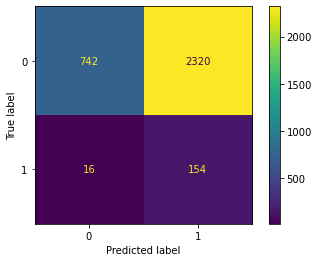

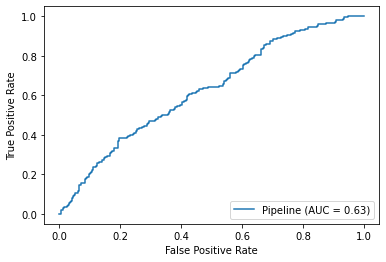

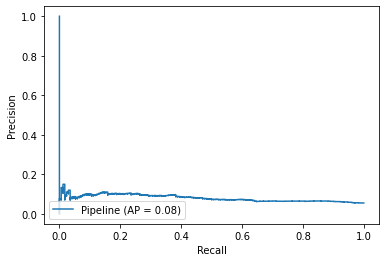

<IPython.core.display.Javascript object>

In [13]:
from sklearn.decomposition import PCA

pca_clf = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="mean"),
    PCA(n_components=4),
    LogisticRegression(solver="liblinear", class_weight="balanced"),
)

pca_clf.fit(X_train, y_train)

# using default
y_hat = pca_clf.predict(X_test)
y_probs = pca_clf.predict_proba(X_test)[:, 1]  # for the "1" class

print(classification_report(y_test, y_hat))

print("Precision: ", precision_score(y_test, y_hat))
print("Recall: ", recall_score(y_test, y_hat))
print("f1 score: ", f1_score(y_test, y_hat))

plot_confusion_matrix(pca_clf, X_test, y_test)

plot_roc_curve(pca_clf, X_test, y_test)
plot_precision_recall_curve(pca_clf, X_test, y_test)


### How many Principal Components?

Three / Four seems enough

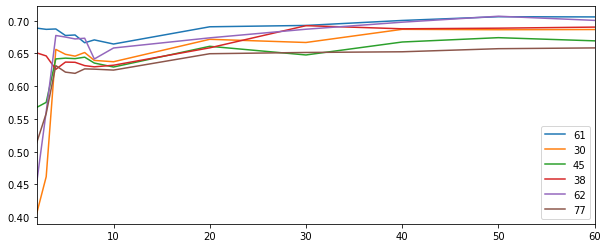

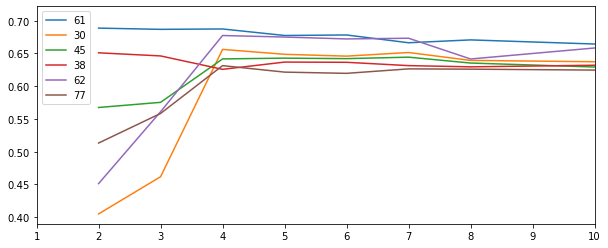

<IPython.core.display.Javascript object>

In [14]:

# can be made easy using the Stratified k-fold: StratifiedKFold

def pca_logit(n_components, X, y, test_size=0.33, random_state=38):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    pca_pipe = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy="mean"),
        PCA(n_components=n_components),
        LogisticRegression(solver="liblinear", class_weight="balanced"),
    )

    pca_pipe.fit(X_train, y_train)

    y_probs = pca_pipe.predict_proba(X_test)[:, 1]  # for the "1" class

    return roc_auc_score(y_test, y_probs)


# # search the best pca components by running lots of logistic regressions with different splitting
# pca_scores = pd.DataFrame()
# for rdn in [61, 30, 45, 38, 62, 77]:
#     print("----")
#     ras = {}
#     for nc in [2, 3, 4, 5, 6, 7, 8, 10, 20, 30, 40, 50, 60]:
#         ras[nc] = pca_logit(nc, X, y, random_state=rdn)
#     #        print(ras[nc])
#     pca_scores[rdn] = pd.Series(ras)
# pca_scores.to_pickle("pca_scores.pkl")

# load the previous saved results
pca_scores = pd.read_pickle("data/pca_scores.pkl")

pca_scores.plot(figsize=(10, 4))
pca_scores.plot(xlim=(1, 10), figsize=(10, 4))


## Feature selection based on different classifiers

### Wrapper methods

Result pickled in 'data/feature_selection.pkl'

In [15]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

X = company_raw.iloc[:, 0:-1].copy()
y = company_raw["bankruptcy_label"]

sfs_clf = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="mean"),
    StandardScaler(),
#    LogisticRegression(solver="liblinear", class_weight="balanced"),
#     KNeighborsClassifier(n_neighbors=3)
     LinearSVC(C=1, class_weight="balanced")
)

feature_file = "data/feature_selection.pkl"

sfs = SFS(
    sfs_clf,
    k_features=10,
#    k_features="parsimonious",
    forward=True,
    floating=False,
    verbose=2,
    scoring="roc_auc",
#    scoring="f1",
    n_jobs=4,
    cv=5,
)

#sfs.fit(X, y)


# sfs_dict = {
#     "lg_roc_auc": sfs1,
#     "lg_f1": sfs2,
#     "svc_roc_auc": sfs3,
#     "svc_f1": sfs4,
#     "knn_3_roc_auc": sfs5,
#     "knn_3_f1": sfs6,
# }

# with open(feature_file, 'wb') as handle:
#     pickle.dump(sfs_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(feature_file, "rb") as handle:
    sd = pickle.load(handle)

# sfs = sd["lg_roc_auc"]
# sfs = sd["lg_f1"]
sfs = sd["svc_roc_auc"]
# sfs = sd["svc_f1"]
# sfs = sd["knn_3_roc_auc"]
# sfs = sd["knn_3_f1"]


<IPython.core.display.Javascript object>

In [16]:
sm = pd.DataFrame(sfs.get_metric_dict()).T
sm.sort_values("avg_score", ascending=False)

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
4,"(7, 15, 38, 44)","[0.7610740291262137, 0.7582440575828591, 0.773338916075681, 0.6908486640672022, 0.758150367675922]",0.748331,"(attr8, attr16, attr40, attr46)",0.0376337,0.0292803,0.0146402
3,"(15, 38, 44)","[0.7621254603280884, 0.7570304653498493, 0.7710046319315417, 0.6860858870018057, 0.7634469944783...",0.747939,"(attr16, attr40, attr46)",0.040163,0.0312482,0.0156241
8,"(4, 7, 12, 15, 30, 38, 44, 52)","[0.7719388182122532, 0.7467097003682626, 0.7690628843587262, 0.6923507706801351, 0.7583283175882...",0.747678,"(attr5, attr8, attr13, attr16, attr31, attr40, attr46, attr54)",0.0373459,0.0290564,0.0145282
5,"(7, 15, 30, 38, 44)","[0.7585317626380985, 0.7568369183126883, 0.77407688482977, 0.6897390940255934, 0.7590505848794913]",0.747647,"(attr8, attr16, attr31, attr40, attr46)",0.0380621,0.0296136,0.0148068
6,"(4, 7, 15, 30, 38, 44)","[0.7639824656846333, 0.7542737278205558, 0.7716902624761207, 0.6852066050820401, 0.7607515766885...",0.747181,"(attr5, attr8, attr16, attr31, attr40, attr46)",0.0404746,0.0314906,0.0157453
7,"(4, 7, 15, 30, 38, 44, 52)","[0.7629938064948107, 0.7493565868764647, 0.7718211079998953, 0.6852589432915499, 0.7635673723601...",0.7466,"(attr5, attr8, attr16, attr31, attr40, attr46, attr54)",0.0404941,0.0315058,0.0157529
9,"(4, 7, 12, 15, 30, 38, 44, 52, 56)","[0.7685595915634417, 0.752374874455976, 0.7745426948944075, 0.6748907439876481, 0.7578729751655195]",0.745648,"(attr5, attr8, attr13, attr16, attr31, attr40, attr46, attr54, attr58)",0.0465592,0.0362247,0.0181123
10,"(4, 7, 12, 15, 16, 30, 38, 44, 52, 56)","[0.7688054486106461, 0.7539075577502512, 0.7654986522911053, 0.6762881741815612, 0.7533718891476...",0.743574,"(attr5, attr8, attr13, attr16, attr17, attr31, attr40, attr46, attr54, attr58)",0.0439542,0.0341979,0.0170989
2,"(15, 44)","[0.7432467777033813, 0.7359129142952796, 0.7262188260539607, 0.6956323764164027, 0.730374479889043]",0.726277,"(attr16, attr46)",0.0210153,0.0163506,0.0081753
1,"(15,)","[0.7368963424840977, 0.7050526238701038, 0.7222489728626383, 0.7220684060398295, 0.7230837673043...",0.72187,"(attr16,)",0.0129843,0.0101022,0.0050511


<IPython.core.display.Javascript object>

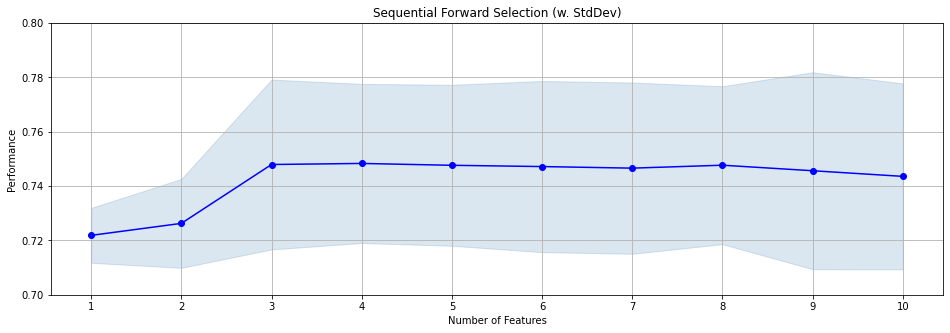

<IPython.core.display.Javascript object>

In [17]:
plot_sfs(sfs.get_metric_dict(), kind="std_dev", figsize=(16, 5))

plt.ylim([0.7, 0.8])
plt.title("Sequential Forward Selection (w. StdDev)")
plt.grid()
plt.show()

In [18]:
# sfs.k_feature_names_

lr_features = sd["lg_roc_auc"].subsets_[3]["feature_names"]
svc_features = sd["svc_roc_auc"].subsets_[3]["feature_names"]


print("Do these selected features make any business sense?\n")
print("Selected feature based on LR")
_ = [ print(f"  {f}:\t{data_dictionary[f]}") for f in lr_features ]

print("\nSelected feature based on SVC")
_ = [ print(f"  {f}:\t{data_dictionary[f]}") for f in svc_features ]



Do these selected features make any business sense?

Selected feature based on LR
  attr26:	(net profit + depreciation) / total liabilities
  attr40:	(current assets - inventory - receivables) / short-term liabilities
  attr46:	(current assets - inventory) / short-term liabilities

Selected feature based on SVC
  attr16:	(gross profit + depreciation) / total liabilities
  attr40:	(current assets - inventory - receivables) / short-term liabilities
  attr46:	(current assets - inventory) / short-term liabilities


### Logistics Regression with selected features

              precision    recall  f1-score   support

           0       0.98      0.33      0.50      3062
           1       0.07      0.89      0.13       170

    accuracy                           0.36      3232
   macro avg       0.53      0.61      0.31      3232
weighted avg       0.93      0.36      0.48      3232

Precision:  0.06888686131386862
Recall:  0.888235294117647
f1 score:  0.12785774767146485


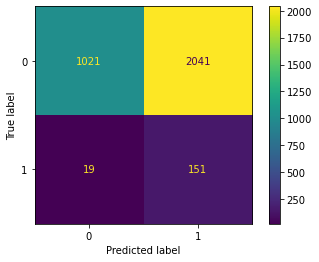

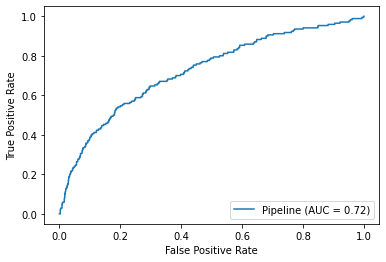

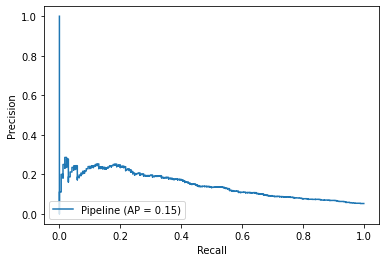

<IPython.core.display.Javascript object>

In [19]:
features = list(lr_features)

X = company_raw[features].sort_index(axis=1).copy()
y = company_raw["bankruptcy_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=38, stratify=y
)


lg_clf = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="mean"),
    LogisticRegression(solver="liblinear", class_weight="balanced"),
)


lg_clf.fit(X_train, y_train)

# using default
y_hat = lg_clf.predict(X_test)

print(classification_report(y_test, y_hat))

print("Precision: ", precision_score(y_test, y_hat))
print("Recall: ", recall_score(y_test, y_hat))
print("f1 score: ", f1_score(y_test, y_hat))

plot_confusion_matrix(lg_clf, X_test, y_test)

plot_roc_curve(lg_clf, X_test, y_test)
plot_precision_recall_curve(lg_clf, X_test, y_test)

### SVC with selected features

              precision    recall  f1-score   support

           0       0.98      0.34      0.50      3062
           1       0.07      0.90      0.13       170

    accuracy                           0.37      3232
   macro avg       0.53      0.62      0.32      3232
weighted avg       0.94      0.37      0.48      3232

Precision:  0.07024793388429752
Recall:  0.9
f1 score:  0.13032367972742762


/usr/local/lib64/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


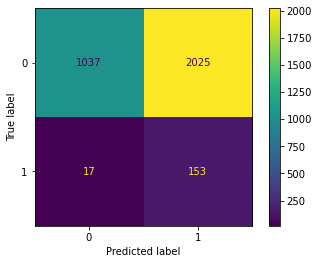

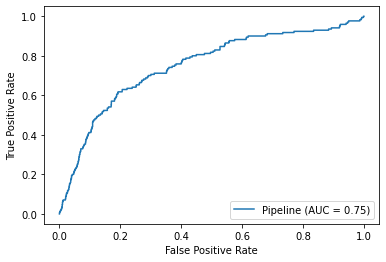

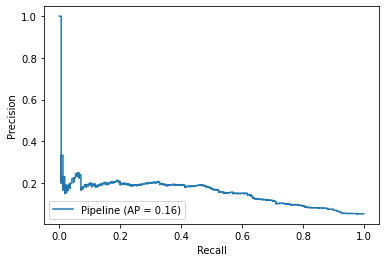

<IPython.core.display.Javascript object>

In [20]:
features = list(svc_features)

X = company_raw[features].sort_index(axis=1).copy()
y = company_raw["bankruptcy_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=38, stratify=y
)

svc_clf = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="mean"),
    StandardScaler(),
    LinearSVC(C=1, class_weight="balanced"),
)


svc_clf.fit(X_train, y_train)

# using default
y_hat = svc_clf.predict(X_test)

print(classification_report(y_test, y_hat))

print("Precision: ", precision_score(y_test, y_hat))
print("Recall: ", recall_score(y_test, y_hat))
print("f1 score: ", f1_score(y_test, y_hat))

plot_confusion_matrix(svc_clf, X_test, y_test)

plot_roc_curve(svc_clf, X_test, y_test)
plot_precision_recall_curve(svc_clf, X_test, y_test)

## Modelling with hyper-parameters Tuning

### SVM

              precision    recall  f1-score   support

           0       0.86      0.00      0.00      3062
           1       0.05      0.99      0.10       170

    accuracy                           0.05      3232
   macro avg       0.45      0.50      0.05      3232
weighted avg       0.81      0.05      0.01      3232



/usr/local/lib64/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


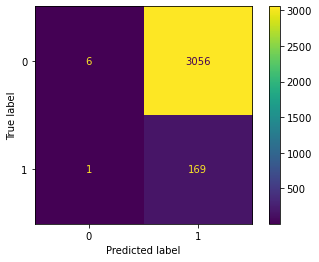

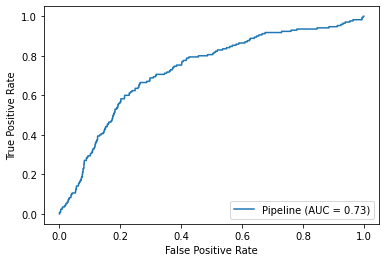

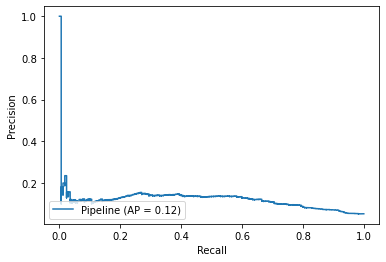

<IPython.core.display.Javascript object>

In [21]:
features = list(svc_features)

X = company_raw[features].sort_index(axis=1).copy()
y = company_raw["bankruptcy_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=38, stratify=y
)


svc_clf = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="mean"),
    StandardScaler(),
    #    SVC(C=1, kernel="rbf", gamma="auto", class_weight="balanced")
    #     SVC(C=50, kernel="linear", gamma="auto", class_weight="balanced"),
    LinearSVC(C=1, class_weight="balanced"),  # same as linear kernel SVC, but faster
)

sample_weight = compute_sample_weight("balanced", y_train)
sw = np.where(sample_weight > 20, sample_weight * 0.1, sample_weight)
svc_clf.fit(X_train, y_train, linearsvc__sample_weight=sw)

# svc_clf.fit(X_train[set_union], y_train, )

y_hat = svc_clf.predict(X_test)

print(classification_report(y_test, y_hat))
plot_confusion_matrix(svc_clf, X_test, y_test)

plot_roc_curve(svc_clf, X_test, y_test)
plot_precision_recall_curve(svc_clf, X_test, y_test)

#### Parameter tuning using grid search with cross-validation

Result pickled in 'data/svc_gs.pkl'

In [22]:
# piped_clf = make_pipeline(
#     StandardScaler(), SVC(class_weight="balanced")
# )
piped_clf = Pipeline([
    ("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ("scaler", StandardScaler()), 
    ("svc", SVC(class_weight="balanced")),
])

parameters = [
    {
        "svc__kernel": ["rbf"],
        "svc__gamma": ["scale", 1e-3, 1e-4],
        "svc__C": [1, 10, 100, 1000],
    },
    {"svc__kernel": ["linear"], "svc__gamma": ["scale", 1e-3, 1e-4], "svc__C": [10, 100, 1000],},
]

# scores = ["precision", "recall"]

svc_gs = GridSearchCV(
    piped_clf,
    parameters,
    scoring="roc_auc",
    verbose=3,
    n_jobs=4,
    cv=5,
)

#svc_gs.fit(X_train, y_train)
svc_gs_file = "data/svc_gs.pkl"

# with open(svc_gs_file, "wb") as handle:
#     pickle.dump(svc_gs, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(svc_gs_file, "rb") as handle:
    svc_gs = pickle.load(handle)

print("Best parameters set found on development set:\n", svc_gs.best_params_)
cv_results_df = pd.DataFrame(svc_gs.cv_results_).set_index("rank_test_score")
cv_results_df[["params", "mean_test_score"]].sort_index()


Best parameters set found on development set:
 {'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}


,params,mean_test_score
rank_test_score,,
1,"{'svc__C': 100, 'svc__gamma': 0.0001, 'svc__kernel': 'linear'}",0.755667
1,"{'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'linear'}",0.755667
1,"{'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}",0.755667
4,"{'svc__C': 10, 'svc__gamma': 0.0001, 'svc__kernel': 'linear'}",0.754779
4,"{'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'linear'}",0.754779
4,"{'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}",0.754779
7,"{'svc__C': 1000, 'svc__gamma': 0.0001, 'svc__kernel': 'linear'}",0.754210
7,"{'svc__C': 1000, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}",0.754210
7,"{'svc__C': 1000, 'svc__gamma': 0.001, 'svc__kernel': 'linear'}",0.754210


<IPython.core.display.Javascript object>

GridCV result:

Best parameters set found on development set:
 {'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}

              precision    recall  f1-score   support

           0       0.98      0.19      0.32      3062
           1       0.06      0.93      0.11       170

    accuracy                           0.23      3232
   macro avg       0.52      0.56      0.21      3232
weighted avg       0.93      0.23      0.30      3232



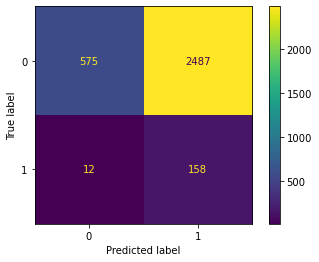

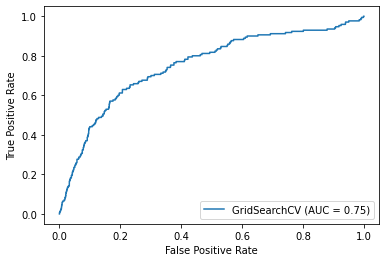

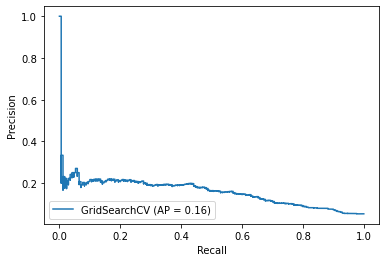

<IPython.core.display.Javascript object>

In [23]:
y_hat = svc_gs.predict(X_test)

print(classification_report(y_test, y_hat))
plot_confusion_matrix(svc_gs, X_test, y_test)

plot_roc_curve(svc_gs, X_test, y_test)
plot_precision_recall_curve(svc_gs, X_test, y_test)

## Gradient boosting trees using XGBoost

CPU times: user 41.4 s, sys: 157 ms, total: 41.5 s
Wall time: 9.02 s
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3062
           1       0.83      0.52      0.64       170

    accuracy                           0.97      3232
   macro avg       0.90      0.76      0.81      3232
weighted avg       0.97      0.97      0.97      3232



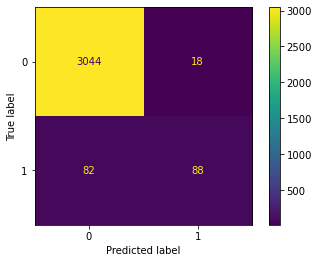

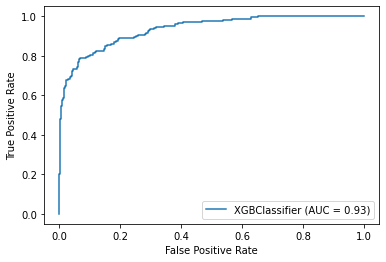

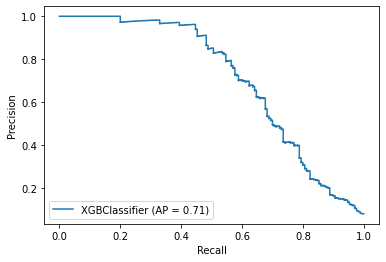

<IPython.core.display.Javascript object>

In [24]:
# Using the XBGoost sklearn interface
from xgboost import XGBClassifier

X = company_raw.iloc[:, 0:-1].copy()
y = company_raw["bankruptcy_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=38, stratify=y
)

xgb_params = {
    "objective": "binary:logistic",
    "n_estimators": 300,  # 300, 400
    "max_depth": 5,
    "learning_rate": 0.1,  # 0.1, 0.05
    "subsample": 0.8,  # 0.8, 1
    #    "tree_method": "gpu_hist",  # "gpu_hist", "auto"
    #    "predictor": "gpu_predictor",
    "scale_pos_weight": 5,
    "min_child_weight": 3,  # 3, 5,
    "colsample_bytree": 0.8,  # 0.5, 0.8
    "reg_alpha": 0.1,  # 0.1, 0.3,
    "gamma": 1,  # 1, 5, 10
    "random_state": 38,
    "verbosity": 1,
    "n_jobs": 4,
}

xgb_clf = XGBClassifier(**xgb_params)

# xgb_clf.fit(X_train, y_train, eval_metric=["auc", "error"])

eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc", "error"]
%time xgb_clf.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)

y_hat = xgb_clf.predict(X_test)
y_prob = xgb_clf.predict_proba(X_test)

print(classification_report(y_test, y_hat))
plot_confusion_matrix(xgb_clf, X_test, y_test)

plot_roc_curve(xgb_clf, X_test, y_test)
plot_precision_recall_curve(xgb_clf, X_test, y_test)

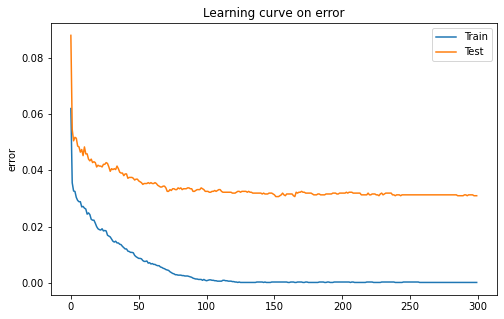

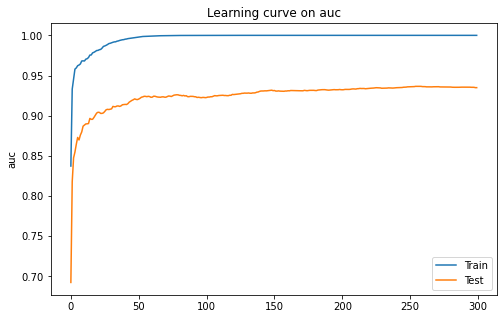

<IPython.core.display.Javascript object>

In [25]:
def plot_learning_curve(xgb_result, eval_metric):
    # retrieve performance metrics

    epochs = len(xgb_result["validation_0"]["error"])
    x_axis = range(0, epochs)

    for m in eval_metric:
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.plot(x_axis, xgb_result["validation_0"][m], label="Train")
        ax.plot(x_axis, xgb_result["validation_1"][m], label="Test")
        ax.legend()
        ax.set_ylabel(m)
        ax.set_title(f"Learning curve on {m}")
        plt.show()


plot_learning_curve(xgb_clf.evals_result(), ["error", "auc"])

attr27    0.049089
attr21    0.044855
attr34    0.036148
attr16    0.031362
attr46    0.028669
attr14    0.025905
attr26    0.023258
attr56    0.021283
dtype: float32

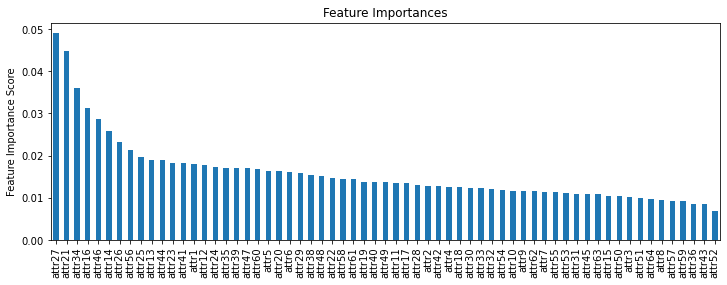

<IPython.core.display.Javascript object>

In [26]:
feature_importance_se = pd.Series(
    xgb_clf.feature_importances_, index=X.columns
).sort_values(ascending=False)

feature_importance_se.plot(
    kind="bar", title="Feature Importances", figsize=(12, 4),
)
plt.ylabel("Feature Importance Score")

feature_importance_se[feature_importance_se > 0.02]

#### Parameter tunning with GridSearchCV

result saved in "data/xgb_gs.pkl"

[14:10:37] WARNING: /workspace/src/gbm/gbtree.cc:336: Loading from a raw memory buffer on CPU only machine.  Changing predictor to auto.
[14:10:37] WARNING: /workspace/src/gbm/gbtree.cc:343: Loading from a raw memory buffer on CPU only machine.  Changing tree_method to hist.
Best parameters set found on development set:
 {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'min_child_weight': 3, 'reg_alpha': 0.1, 'scale_pos_weight': 5, 'subsample': 1.0}

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3062
           1       0.82      0.52      0.64       170

    accuracy                           0.97      3232
   macro avg       0.90      0.76      0.81      3232
weighted avg       0.97      0.97      0.97      3232



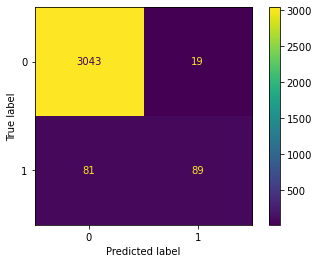

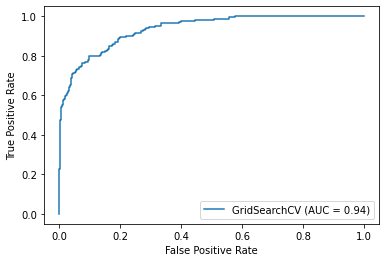

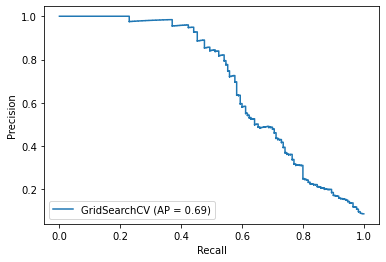

<IPython.core.display.Javascript object>

In [27]:
xgb_gs_file = "data/xgb_gs.pkl"

xgb_params = {
    "objective": "binary:logistic",
    "n_estimators": 200,  # 500
    "max_depth": 3,  # 3, 5
    "learning_rate": 0.1,  # 0.05
    "subsample": 0.8,
    #    "tree_method": "auto",
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    "scale_pos_weight": 5,
    "min_child_weight": 5,
    "colsample_bytree": 0.5,
    "reg_alpha": 0.3,
    "gamma": 5,
    "random_state": 38,
    "verbosity": 1,
    "n_jobs": 1,
}


xgb_gs_parameters = [
    {
        #         "n_estimators": range(200, 600, 100),
        "learning_rate": [0.02, 0.05, 0.1],
        #         "max_depth": [4, 5, 6],
        #         "tree_method": ["exact", "approx", "hist"],
        "min_child_weight": [2, 3, 5, 10],
        "reg_alpha": [0.1, 1, 10],
        "scale_pos_weight": [5, 10],
        "gamma": [0, 1, 5, 10],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.5, 0.7, 0.8],
    }
]

xgb_clf = XGBClassifier(**xgb_params)

xgb_gs = GridSearchCV(
    xgb_clf, xgb_gs_parameters, scoring="roc_auc", verbose=1, n_jobs=4, cv=3,
)

# xgb_gs.fit(X_train, y_train)

# # pickle the search result
# with open(xgb_gs_file, "wb") as handle:
#     pickle.dump(xgb_gs, handle, protocol=pickle.HIGHEST_PROTOCOL)

# to load the previouse search result
with open(xgb_gs_file, "rb") as handle:
    xgb_gs = pickle.load(handle)

print("Best parameters set found on development set:\n", xgb_gs.best_params_)
print()

y_true, y_pred = y_test, xgb_gs.predict(X_test)
print(classification_report(y_true, y_pred))
plot_confusion_matrix(xgb_gs, X_test, y_test)
plot_roc_curve(xgb_gs, X_test, y_test)

plot_precision_recall_curve(xgb_gs, X_test, y_test)

# cv_results = pd.DataFrame(xgb_gs.cv_results_).set_index("rank_test_score")
# cv_results_df


r = """
Best parameters set found on development set:
{
 'colsample_bytree': 0.8, 
 'gamma': 0, 
 'learning_rate': 0.05, 
 'min_child_weight': 3, 
 'reg_alpha': 0.1, 
 'scale_pos_weight': 5, 
 'subsample': 1.0
}
 
"""

In [28]:
xgb_gs_file = "data/xgb_gs.pkl"

with open(xgb_gs_file, "wb") as handle:
    pickle.dump(xgb_gs, handle, protocol=pickle.HIGHEST_PROTOCOL)


# # to load the previouse trained results for saving time
# with open(xgb_gs_file, "rb") as handle:
#     xgb_gs = pickle.load(handle)

# print("Best parameters set found on development set:\n", xgb_gs.best_params_)


<IPython.core.display.Javascript object>

Grid scores on development set:
0.928 (+/-0.003) for {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.02, 'min_child_weight': 2, 'reg_alpha': 0.1, 'scale_pos_weight': 5, 'subsample': 0.8}
0.932 (+/-0.003) for {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.02, 'min_child_weight': 2, 'reg_alpha': 0.1, 'scale_pos_weight': 5, 'subsample': 1.0}
0.927 (+/-0.007) for {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.02, 'min_child_weight': 2, 'reg_alpha': 0.1, 'scale_pos_weight': 10, 'subsample': 0.8}
0.929 (+/-0.001) for {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.02, 'min_child_weight': 2, 'reg_alpha': 0.1, 'scale_pos_weight': 10, 'subsample': 1.0}
0.928 (+/-0.004) for {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.02, 'min_child_weight': 2, 'reg_alpha': 1, 'scale_pos_weight': 5, 'subsample': 0.8}
0.931 (+/-0.003) for {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.02, 'min_child_weight': 2, 'reg_alpha': 1, 'scale_pos_weight': 5, 'sub

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3062
           1       0.82      0.52      0.64       170

    accuracy                           0.97      3232
   macro avg       0.90      0.76      0.81      3232
weighted avg       0.97      0.97      0.97      3232




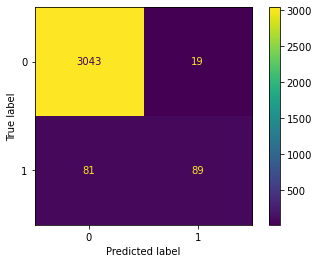

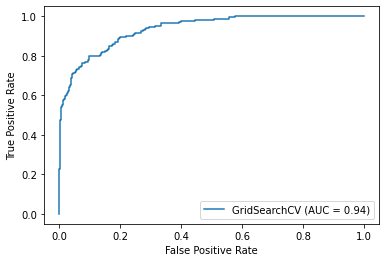

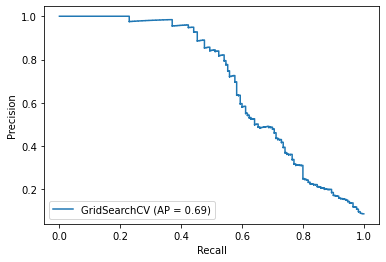

<IPython.core.display.Javascript object>

In [29]:
print("Grid scores on development set:")
means = xgb_gs.cv_results_["mean_test_score"]
stds = xgb_gs.cv_results_["std_test_score"]

for mean, std, params in zip(means, stds, xgb_gs.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, xgb_gs.predict(X_test)
print(classification_report(y_true, y_pred))
print()
plot_confusion_matrix(xgb_gs, X_test, y_test)
plot_roc_curve(xgb_gs, X_test, y_test)

plot_precision_recall_curve(xgb_gs, X_test, y_test)

## Conclusion and future works

Important indicators for company bankruptcy:
 * attr27: profit on operating activities / financial expenses
 * attr21: sales (n) / sales (n-1)
 * attr34: operating expenses / total liabilities
 * attr16: (gross profit + depreciation) / total liabilities
 * attr46: (current assets - inventory) / short-term liabilities
 * attr14: (gross profit + interest) / total assets
 * attr26: (net profit + depreciation) / total liabilities
 * attr56: (sales - cost of products sold) / sales
 * attr40: (current assets - inventory - receivables) / short-term liabilities

Gradient boosting trees perform best among tried modelling approaches. Best auc_roc=0.94.

Advantages of using the XGBoost:
 * Faster algorithm with GPU support
 * Can handle missing values so no need of imputation
 * Colinearity is no problem because splitting among them has no effect on reducing errors.

Future works:
 * Other imputation strategies for LR and SVC
 * Classification and dimension reduction using LDA/QDA
 * Over sampling using SMOTE 
 * Feature selection using multivariate filter methods such as mRMR
 * Modelling using other ensemble approaches, such as StackingClassifier


## Submission

### Final model

In [31]:
import pandas as pd
from xgboost import XGBClassifier

assert company_raw.shape == (9792, 64)
assert test_company_raw.shape == (5910, 63)

X = company_raw.iloc[:, 0:-1].copy()
y = company_raw["bankruptcy_label"]

xgb_params = {
    "objective": "binary:logistic",
    "n_estimators": 500,
    "max_depth": 5,
    "learning_rate": 0.05,
    "subsample": 1,
    "tree_method": "auto",
    "scale_pos_weight": 5,
    "min_child_weight": 3,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.1,
    "gamma": 0,
#    "random_state": 38,
    "verbosity": 1,
    "n_jobs": 4,
}

clf = XGBClassifier(**xgb_params)

clf.fit(X, y, verbose=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0.1, reg_lambda=1, scale_pos_weight=5, subsample=1,
              tree_method='auto', validate_parameters=1, verbosity=1)

<IPython.core.display.Javascript object>

### Prediction and submission

In [32]:
test_final = pd.read_csv("data/Test Dataset.csv")

test_final["bankruptcy_label"] = clf.predict(test_company_raw)

# test_final.to_csv("submission.csv", index=False)

display(test_final.head())

,company_id,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,...,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs /total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities *365) / sales,sales / short-term liabilities,sales / fixed assets,bankruptcy_label
0,1,-463.890,0.00000,0.00000,NaN,0.000,-463.890,-463.890,NaN,0.87160,...,-0.14732,-1.73840,1.1473,0.0,6.9498,NaN,0.000,NaN,28999.0000,0
1,2,-32.052,72.41600,-72.06700,0.004819,-3945.800,-32.052,-32.090,-0.98657,0.43456,...,-1.30120,0.44864,2.3012,0.0,14.3660,20.827,9090.500,0.040152,4.4661,0
2,3,-10.292,8.44190,-7.44190,0.118460,-92.123,-27.984,-10.292,-0.88154,22.07000,...,-0.37260,1.38290,1.4469,0.0,100.6000,517.570,139.610,2.614400,NaN,0
3,4,-10.083,25.64000,-24.66200,0.038119,-211.840,-34.052,-10.083,-0.96100,37.80700,...,-0.11122,0.40922,1.2638,0.0,NaN,49.422,247.530,1.474600,1670.5000,0
4,5,-5.112,0.86999,0.76328,5.250900,25.249,0.000,-5.112,0.14943,5.79320,...,-0.68103,-39.32200,1.8519,0.0,NaN,13.292,11.313,32.264000,101.3500,0


<IPython.core.display.Javascript object>